# Tutorial 7 - Effect of illumination coherence


### Purpose


At the end of the notebook, there will be an optional (starred) section:

* **(\*):** Figures for the condenser NA section of the paper.

## 0. Initial setup

### 0.A. Setting up your workspace

### 0.B. Sample description and experimental parameters

### 0.C. Let's get started

In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels indicating the condenser (approximate) iris aperture.

In [2]:
# directory containing the videos
main_directory = '../DATASET/CONDENSER_NA/'

# high frame rate videos file names (including enclosing folder)
file_names_fast = [
    'PS_252nm_cond_0perc_blue_ill_phi_1e-4/fast.nd2',
    'PS_252nm_cond_25perc_blue_ill_phi_1e-4/fast.nd2',
    'PS_252nm_cond_50perc_blue_ill_phi_1e-4/fast.nd2',
    'PS_252nm_cond_100perc_blue_ill_phi_1e-4/fast.nd2',
]

# create full paths
file_paths_fast = [os.path.join(main_directory, fn) for fn in file_names_fast]

# low frame rate videos file names (including enclosing folder)
file_names_slow = [
    'PS_252nm_cond_0perc_blue_ill_phi_1e-4/slow.nd2',
    'PS_252nm_cond_25perc_blue_ill_phi_1e-4/slow.nd2',
    'PS_252nm_cond_50perc_blue_ill_phi_1e-4/slow.nd2',
    'PS_252nm_cond_100perc_blue_ill_phi_1e-4/slow.nd2',
]

# create full paths
file_paths_slow = [os.path.join(main_directory, fn) for fn in file_names_slow]

# list of labels
labels = [
    r'NA$_c$ 0.037',
    r'NA$_c$ 0.1',
    r'NA$_c$ 0.18',
    r'NA$_c$ 0.3',
]

In [35]:
# experimental acquisition parameters
pixel_size = 6.5 / 20    # microns per pixel
frame_rate_fast = 111    # frames per second
frame_rate_slow = 1      # frames per second

# list of estimated numerical apertures
NA_c = [0.0372, 0.0993, 0.179, 0.3]

## 1. Structure function calculation

### 1.A. Load and visualize images

<IPython.core.display.Javascript object>


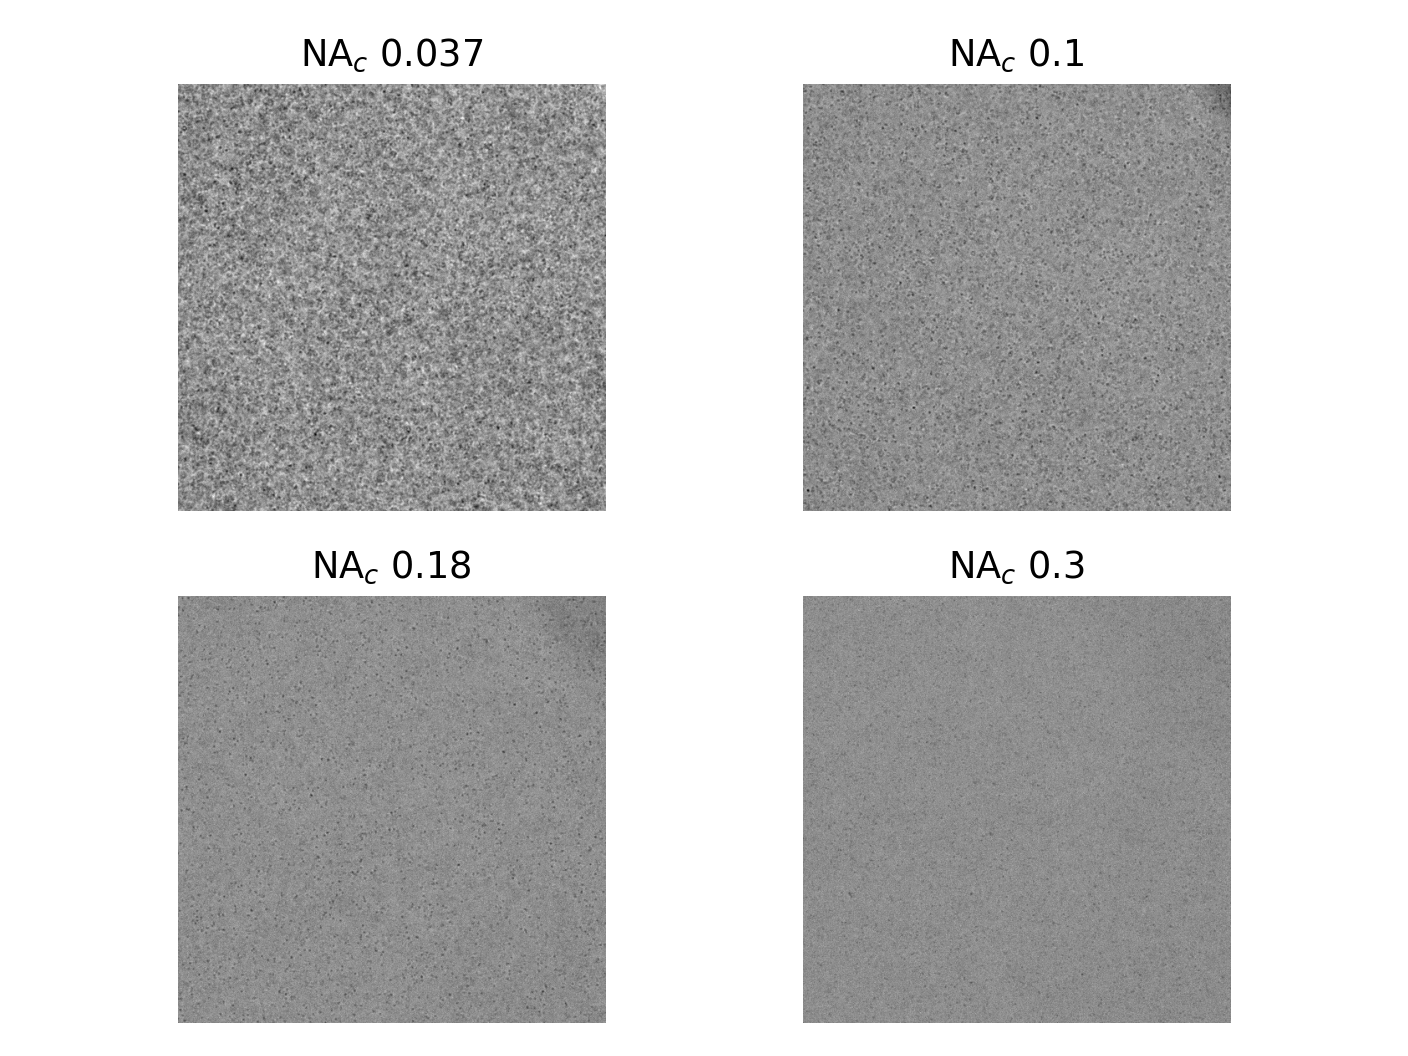

In [4]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2, nrows=2)
axs = gs.subplots()

# read the images
images = []
for path in file_paths_fast:
    images.append(fd.read_images(path, seq=[0])[0])
images = np.array(images)

# compute max and min
vmin = np.min(images)
vmax = np.max(images)

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

### 1.B-C. Structure function and azimuthal average calculation

In [5]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
#CORE = 'py'
#CORE = 'cpp'
CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

aa = []

for n, (ffast, fslow) in enumerate(zip(file_paths_fast, file_paths_slow)):
    # analyze fast acquisition
    # notify user on progress
    print(f'Analyzing fast movie, set #{n+1} of {len(file_paths_fast)} ...')
    
    # read image sequence
    img_seq = fd.read_images(ffast)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size
    dqt.set_frame_rate(frame_rate_fast)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # analyze slow acquisition
    # notify user on progress
    print(f'Analyzing slow movie, set #{n+1} of {len(file_paths_slow)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fslow)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size
    dqt.set_frame_rate(frame_rate_slow)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # melt the azimuthal averages
    aa_melt = fd.azimuthalaverage.melt(aa_fast, aa_slow)
    
    # resample
    # get 200 logspaced integers and rescale then with proper time
    max_tau = int(aa_melt.tau[-1] / aa_melt.tau[0])
    new_taus = fd.lags.logspace_int(max_tau, num=200, endpoint=True) * aa_melt.tau[0]
    aa.append(aa_melt.resample(new_taus))
    
    # delete unused variables
    del aa_fast, aa_slow, aa_melt
    gc.collect()

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie, set #1 of 4 ...
Analyzing slow movie, set #1 of 4 ...
Analyzing fast movie, set #2 of 4 ...
Analyzing slow movie, set #2 of 4 ...
Analyzing fast movie, set #3 of 4 ...
Analyzing slow movie, set #3 of 4 ...
Analyzing fast movie, set #4 of 4 ...
Analyzing slow movie, set #4 of 4 ...


## 2. Fit the data

### 2.A. Estimate noise and amplitude

In [7]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    # estimate noise term using the 'polynomial' method
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit', num_points=5)
    Bq.append(B_est)
    
    # estimate total amplitude
    Aq_plus_Bq = 2 * a.var
    
    # estimate static amplitude 
    Aq.append(Aq_plus_Bq - B_est)

### 2.B. Fit with simple exponential model

In [8]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate ...

In [11]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=False, return_model_results=True)
    fit_res.append(fr)
    model_res.append(mr)

Visualize the output from the fit...

<IPython.core.display.Javascript object>


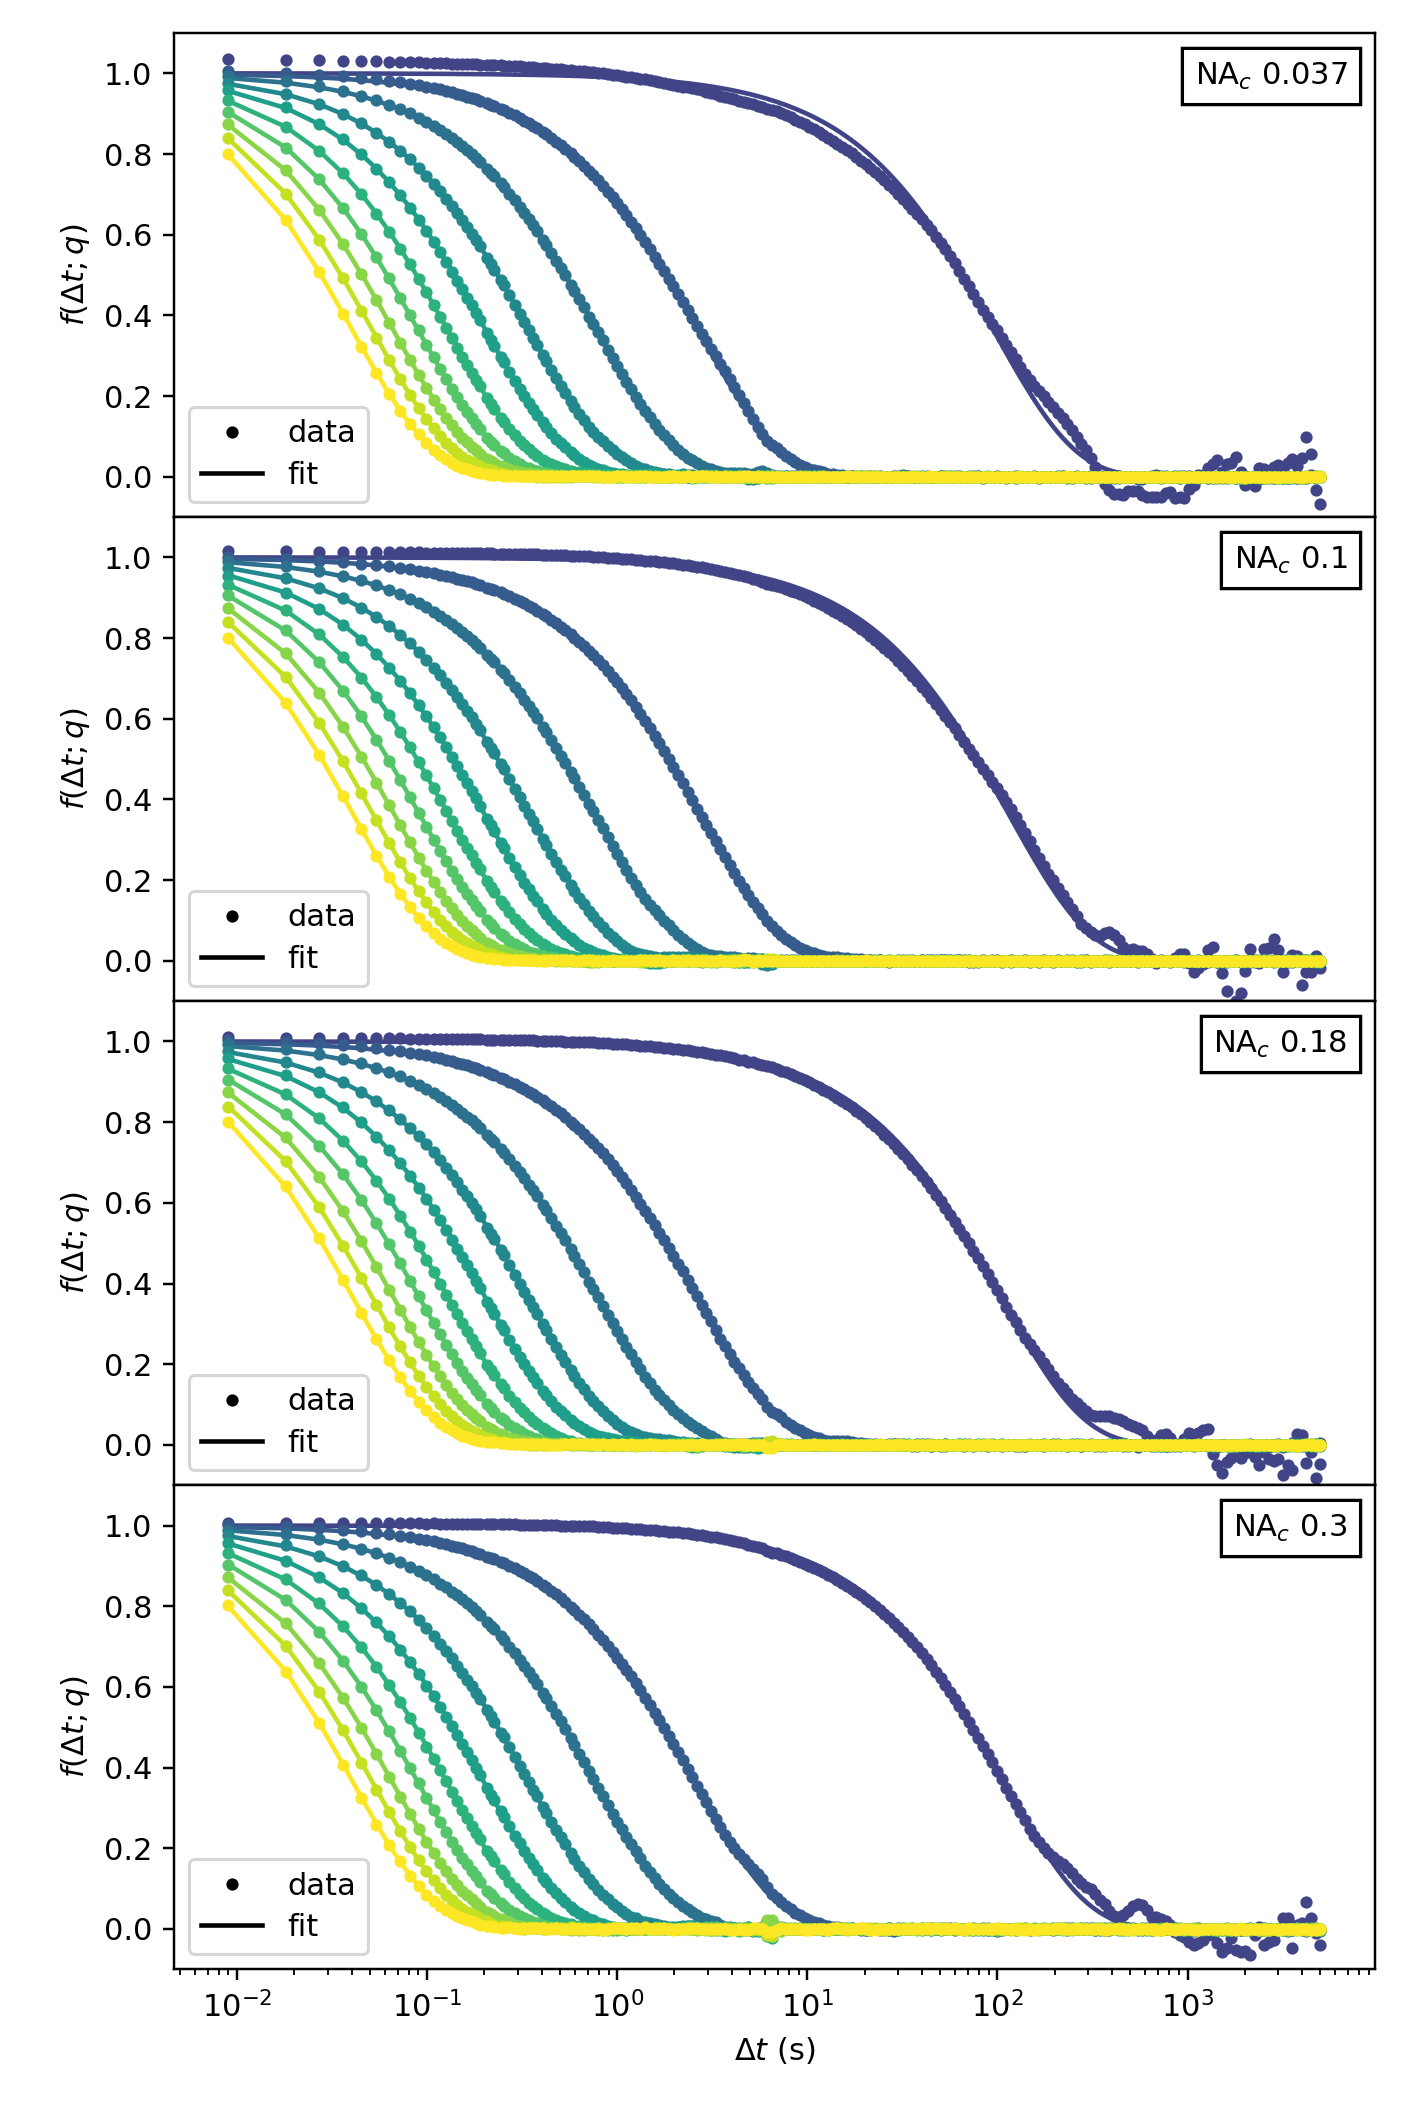

In [12]:
fig = plt.figure()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

# select range of wave vector indices
q_min = 0.1
q_max = 5

idx_min = np.argmin(np.abs(aa[0].k - q_min))
idx_max = np.argmin(np.abs(aa[0].k - q_max))
k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

cspace = color_space(len(k_list))

# plot curves
for ax, a, fr, mr, l in zip(axs, aa, fit_res, model_res, labels):
    for k_idx, c in zip(k_list, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (a.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(a.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True, loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black', label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)')

fig.tight_layout();

Visualize the fit parameters...

<IPython.core.display.Javascript object>


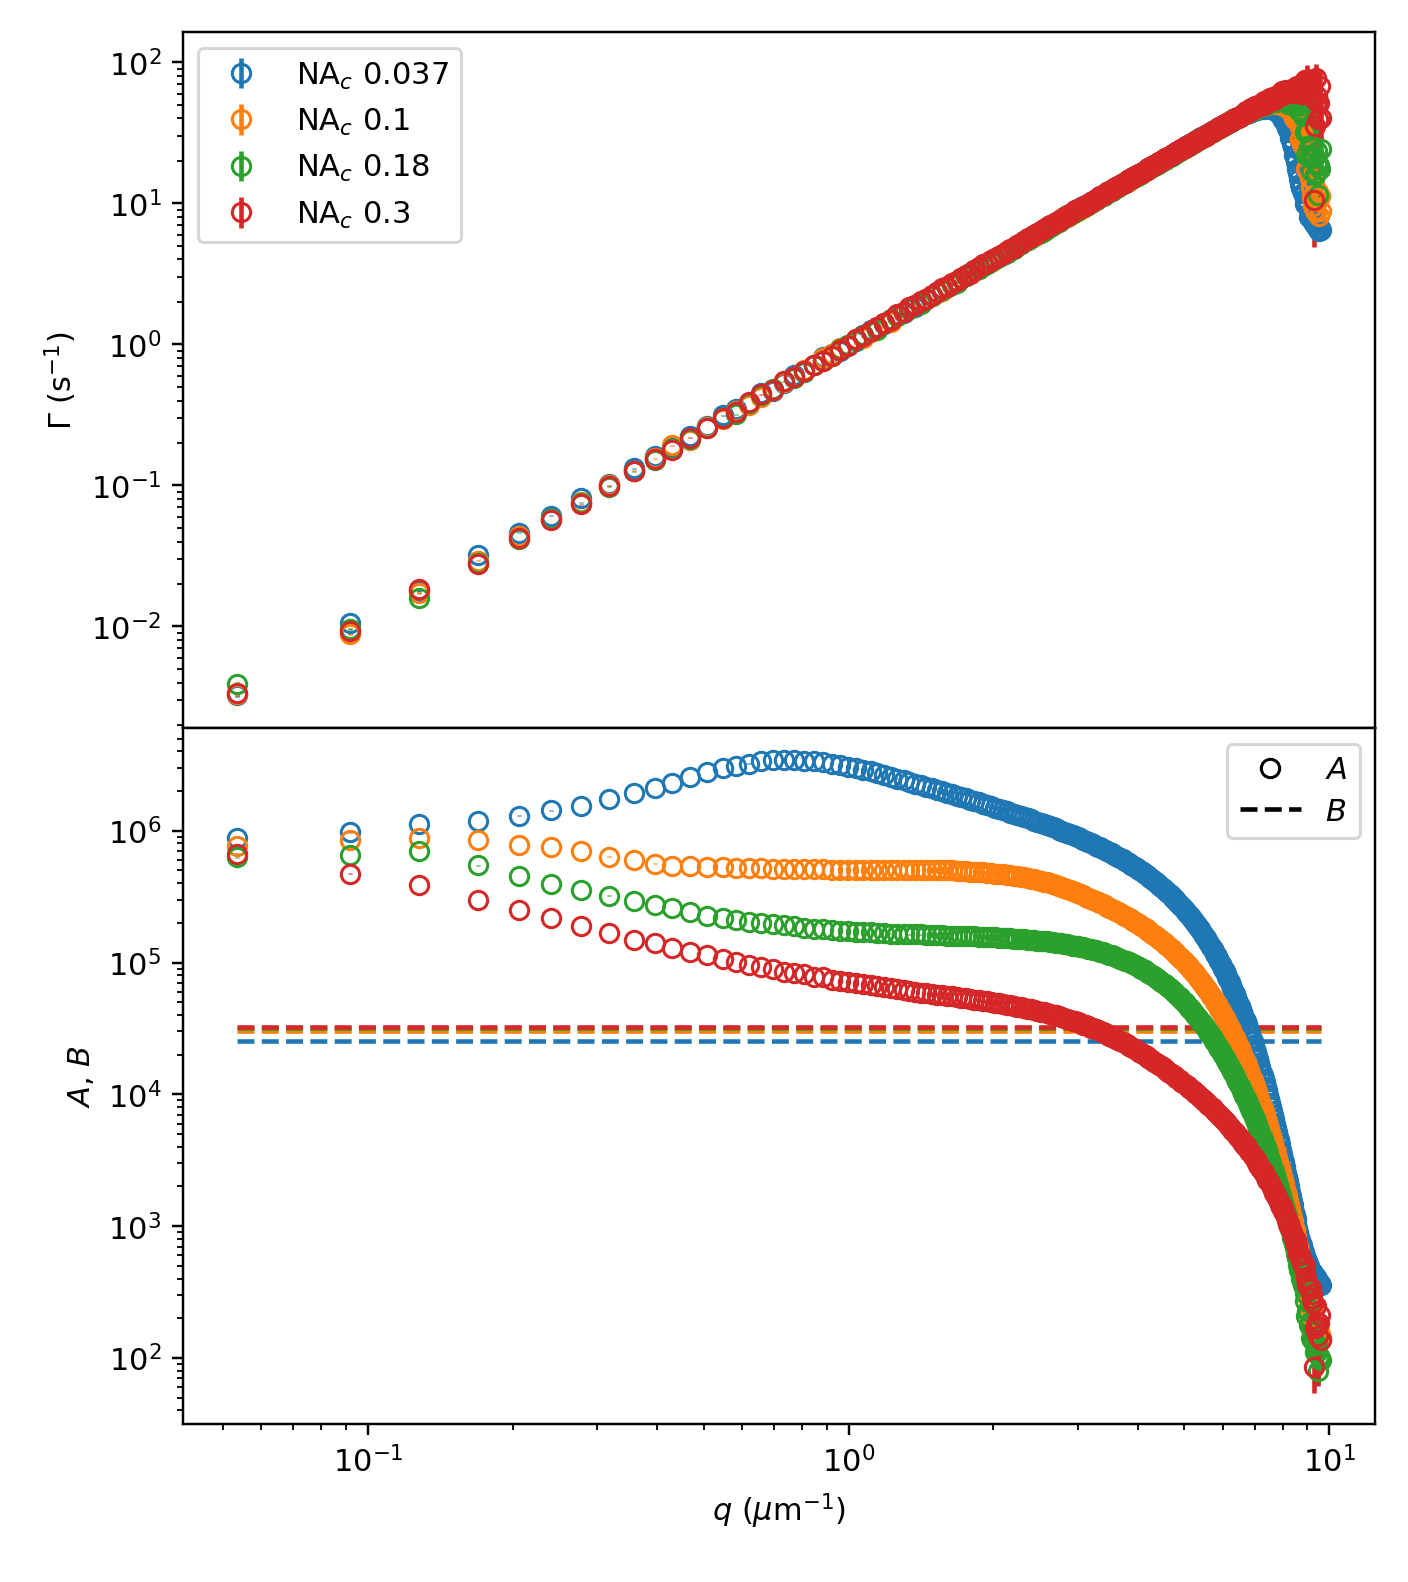

In [18]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res, labels)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        np.full_like(tmp_df['B'], fill_value=tmp_df['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

Comment on high q region (one should use windowing)...
We filter out $q>6.5 \, \mathrm{µm^{-1}}$

In [19]:
fit_res_filtered = []

q_max = 6.5

for fr in fit_res:
    # remove non-succesful fits and nans
    tmp_df = fr[fr['success']].dropna()
    
    # filter q range
    tmp_df = tmp_df[(tmp_df['k'] <= q_max)]
    
    # append to list
    fit_res_filtered.append(tmp_df)

We plot again the filtered results

<IPython.core.display.Javascript object>


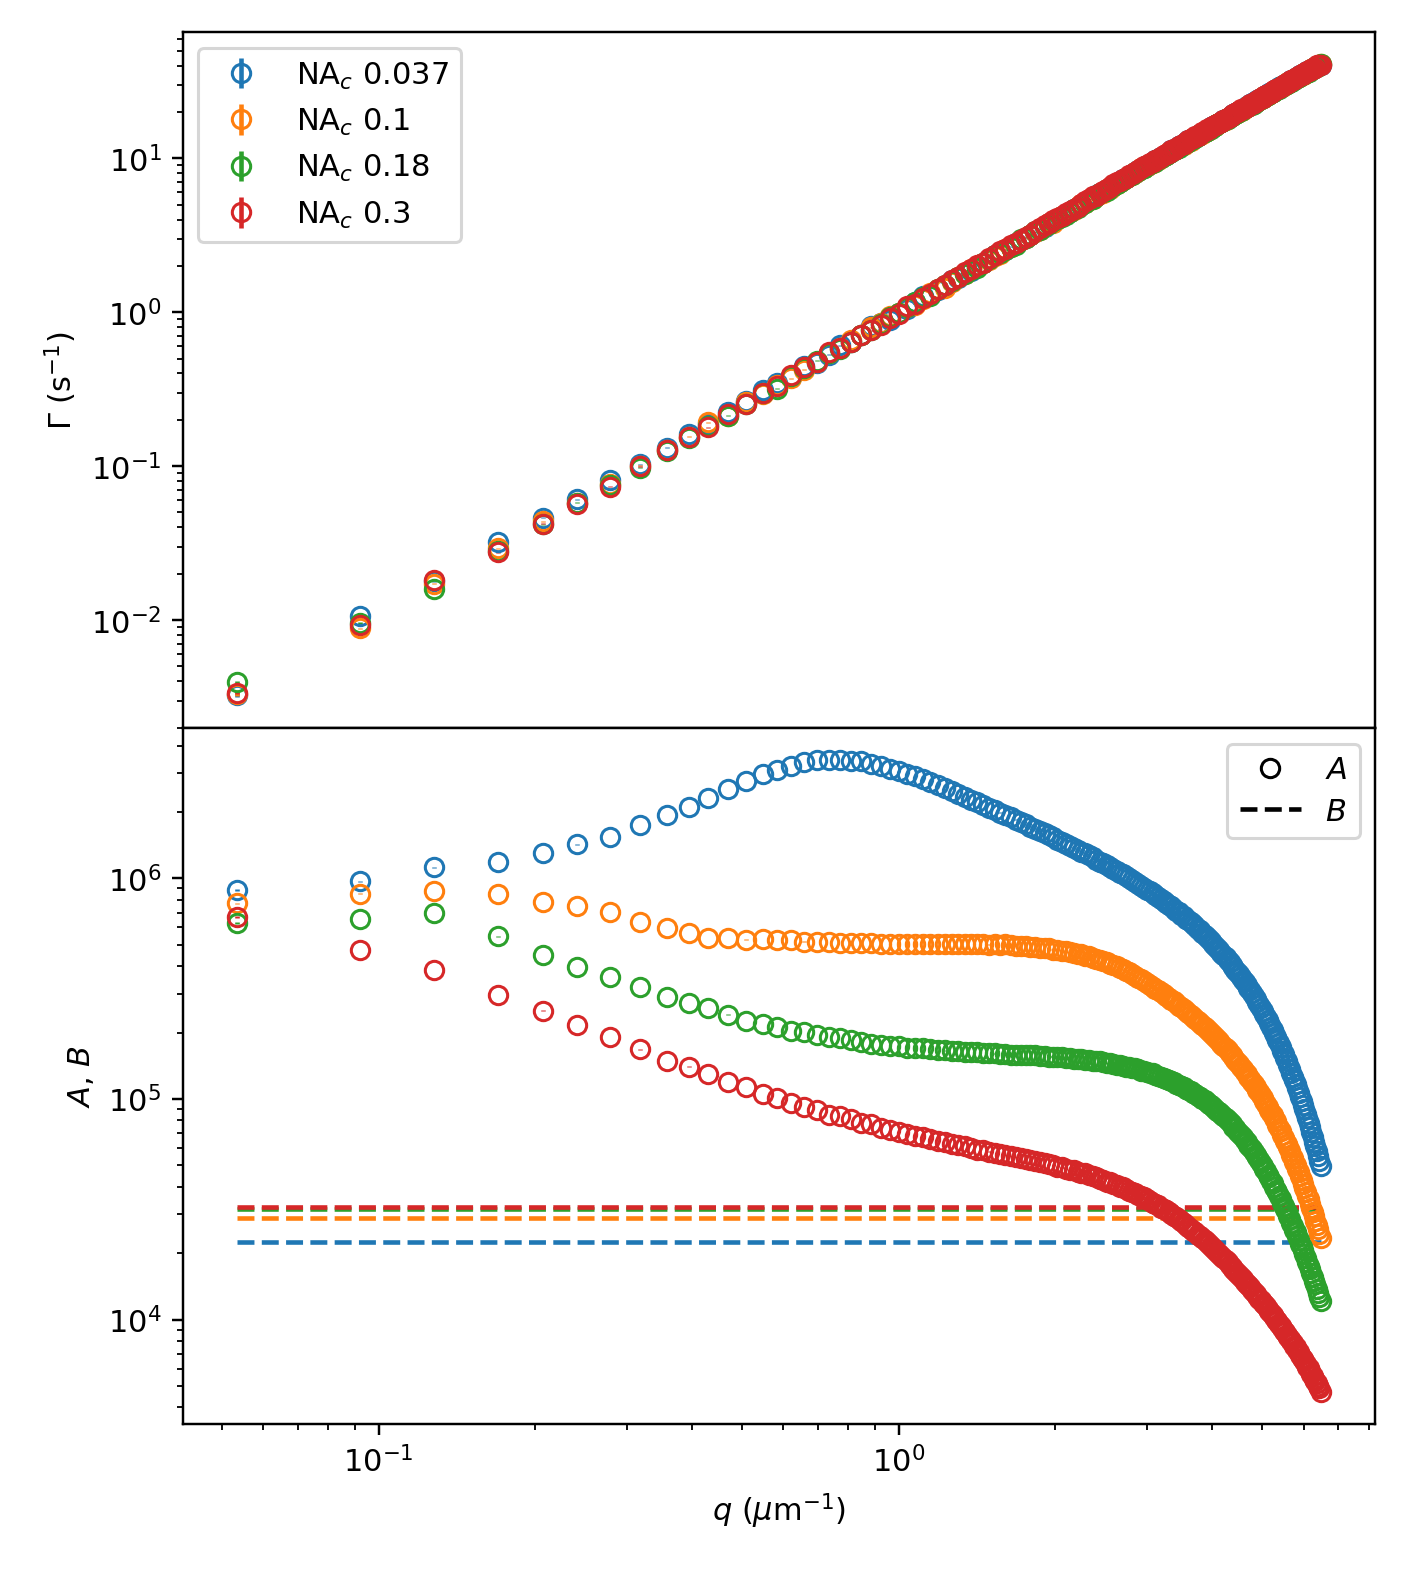

In [20]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res_filtered, labels)):
    # display the full data (with transparency)
    axs[0].errorbar(
        fr['k'],
        fr['Gamma'],
        yerr=fr['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        fr['k'],
        fr['A'],
        yerr=fr['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        fr['k'],
        np.full_like(fr['B'], fill_value=fr['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

## 3. Amplitude model

λ: 435.9765125671869 nm
Δλ: 8.582654093524384 nm


<IPython.core.display.Javascript object>


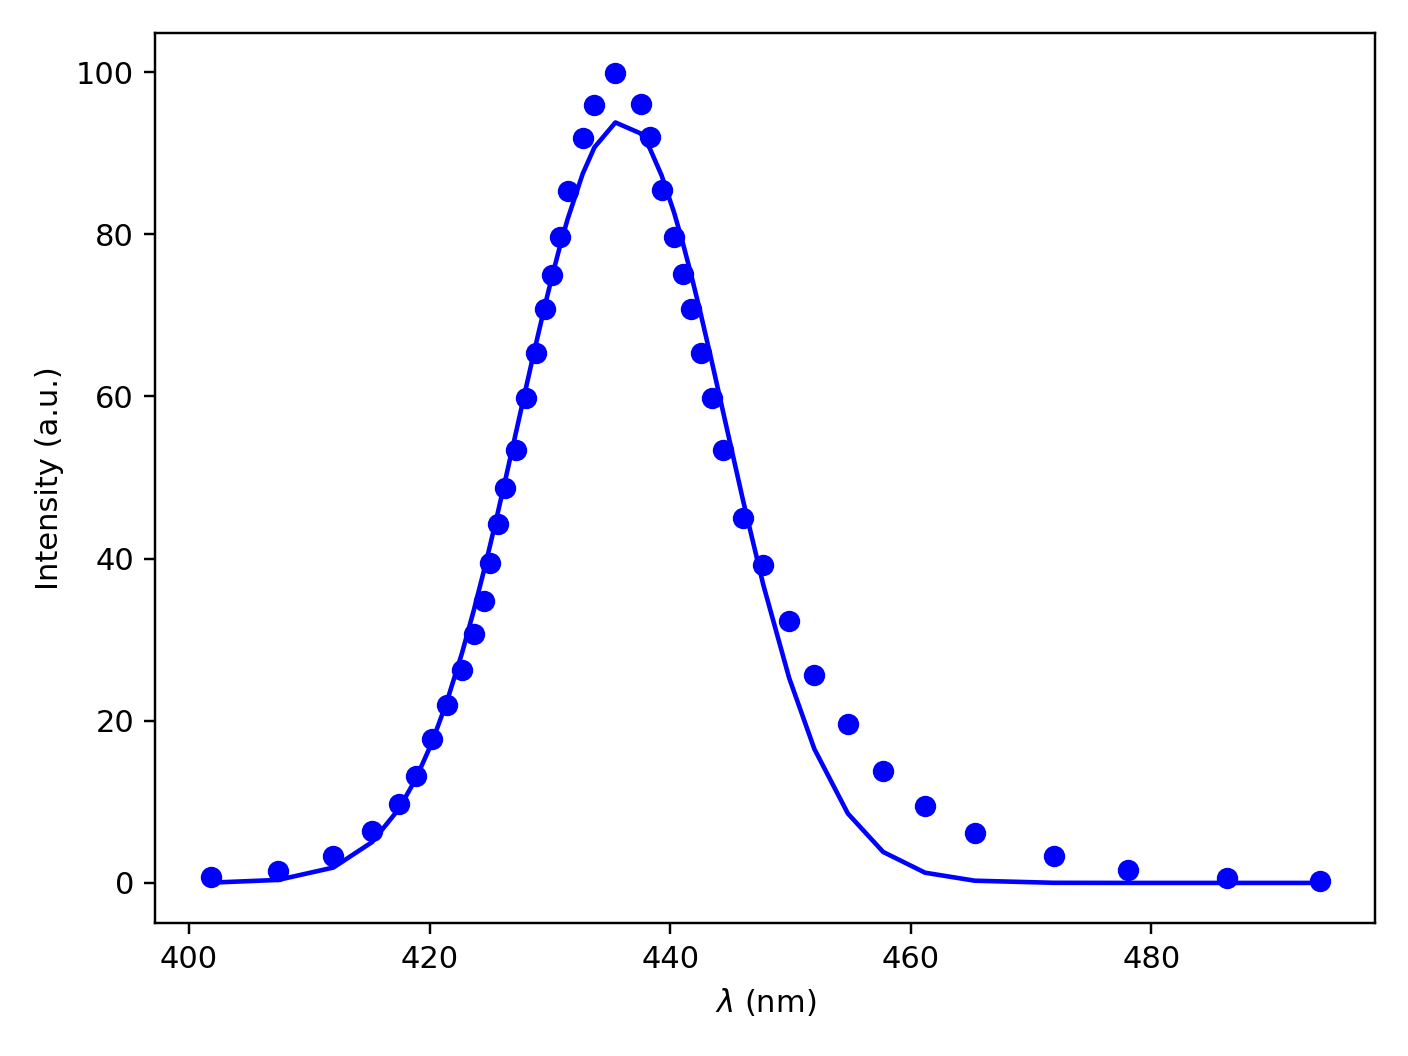

In [24]:
# import blue led spectrum data
blue_spec = pd.read_csv('blue_spectrum.dat')

# define gaussian model
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-0.5*(x-mu)**2/sigma**2)

spectrum_model = lmfit.Model(gaussian)
spectrum_model.set_param_hint("amp", min=0.0, value=100.0)
spectrum_model.set_param_hint("mu", min=400, max=700, value=450)
spectrum_model.set_param_hint("sigma", min=0, value=10)

spectrum_fit_res = fit(spectrum_model, xdata=blue_spec['lambda'], ydata=blue_spec['intensity'])

print(f'λ: {spectrum_fit_res.params["mu"].value} nm')
print(f'Δλ: {spectrum_fit_res.params["sigma"].value} nm')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(blue_spec['lambda'], blue_spec['intensity'], 'bo')
ax.plot(blue_spec['lambda'], spectrum_fit_res.best_fit, 'b-')

ax.set_xlabel(r'$\lambda$ (nm)')
ax.set_ylabel('Intensity (a.u.)')

fig.tight_layout();

In [31]:
# compute the phase delay of the particle from Mie theory
precompute_phase = True

if precompute_phase:
    import miepython

    R = 0.126   # particle radius in microns
    mp = 1.586  # particle refractive index
    ms = 1.363  # solvent refractive index
    m = mp / ms # normalized refractive index

    lambda_0 = spectrum_fit_res.params["mu"].value * 1e-3   # wavelength in microns
    k = 2 * np.pi * ms / lambda_0

    x = R * k

    mu = 1.0   # cos(0)

    s1, s2 = miepython.mie_S1_S2(m, x, mu)
    phase = np.pi / 2 - np.angle(s1)
    
    print(f'Phase computed from Mie : {phase:.4f} rad')

# To be sure we have the phase even without Mie, we copy the value outside the if clause
phase = 0.24163512797082087    # rad

print(f'Phase delay is : {phase:.4f} rad')

Phase computed from Mie : 0.2416 rad
Phase delay is : 0.2416 rad


In [33]:
from lmfit import Parameters, minimize, report_fit

# define the amplitude model
def A_model(x, a, NA_c, NA_o, l, lambda_0, delta_lambda, alpha):
    q = x   # just rename x to q for better comparison with formulas
    
    # derived quantities
    k0 = 2 * np.pi / lambda_0
    q_norm = q / k0
    
    sigma_c = NA_c / 2
    sigma_o = NA_o / 2
    M = sigma_c / sigma_o
    q_ro = k0 * sigma_o * np.sqrt((1 + 2 * M**2)/(1 + M**2))
    
    dl_norm = delta_lambda / lambda_0
    
    Sigma = 1 / l
    
    # final quantities
    qz = (k0 * q_norm**2 / 2) * (1 - 2 * M**2 - (q_norm * dl_norm / sigma_o)**2)
    
    dq = q * np.sqrt(sigma_c**2 + (q_norm * dl_norm / 2)**2)
    dq = np.sqrt(dq**2 + Sigma**2)
    
    den = 1 + (q / q_ro * dl_norm)**2
    C2 = np.exp(-(q / q_ro)**2 / den) / den
    
    return a * C2 / dq * ((1 + alpha**2) - (1 - alpha**2) * np.exp(-(qz / dq)**2))

# define helper function for global fit
def A_dataset(params, n, x):
    # unpack parameters
    a = params[f'a_{n}']
    NA_c = params[f'NA_c_{n}']
    NA_o = params[f'NA_o']
    l = params['l']
    lambda_0 = params['lambda_0']
    delta_lambda = params['delta_lambda']
    alpha = params['alpha']
    return A_model(x, a, NA_c, NA_o, l, lambda_0, delta_lambda, alpha)


# define objective function for global fit
def objective(params, x, data, start_idx):
    '''Calculate total residual for fits of A to several data sets.'''
    resid = np.zeros_like(data)
    
    ndata = len(start_idx) - 1
    
    for n in range(ndata):
        start = start_idx[n]
        end = start_idx[n+1]
        resid[start:end] = data[start:end] - A_dataset(params, n, x[start:end])
        
    return resid

We plot the amplitude varying different parameters (NEED TO FIX THE AMPLITUDE AND CHOOSE GOOD PARAMETERS).

<IPython.core.display.Javascript object>


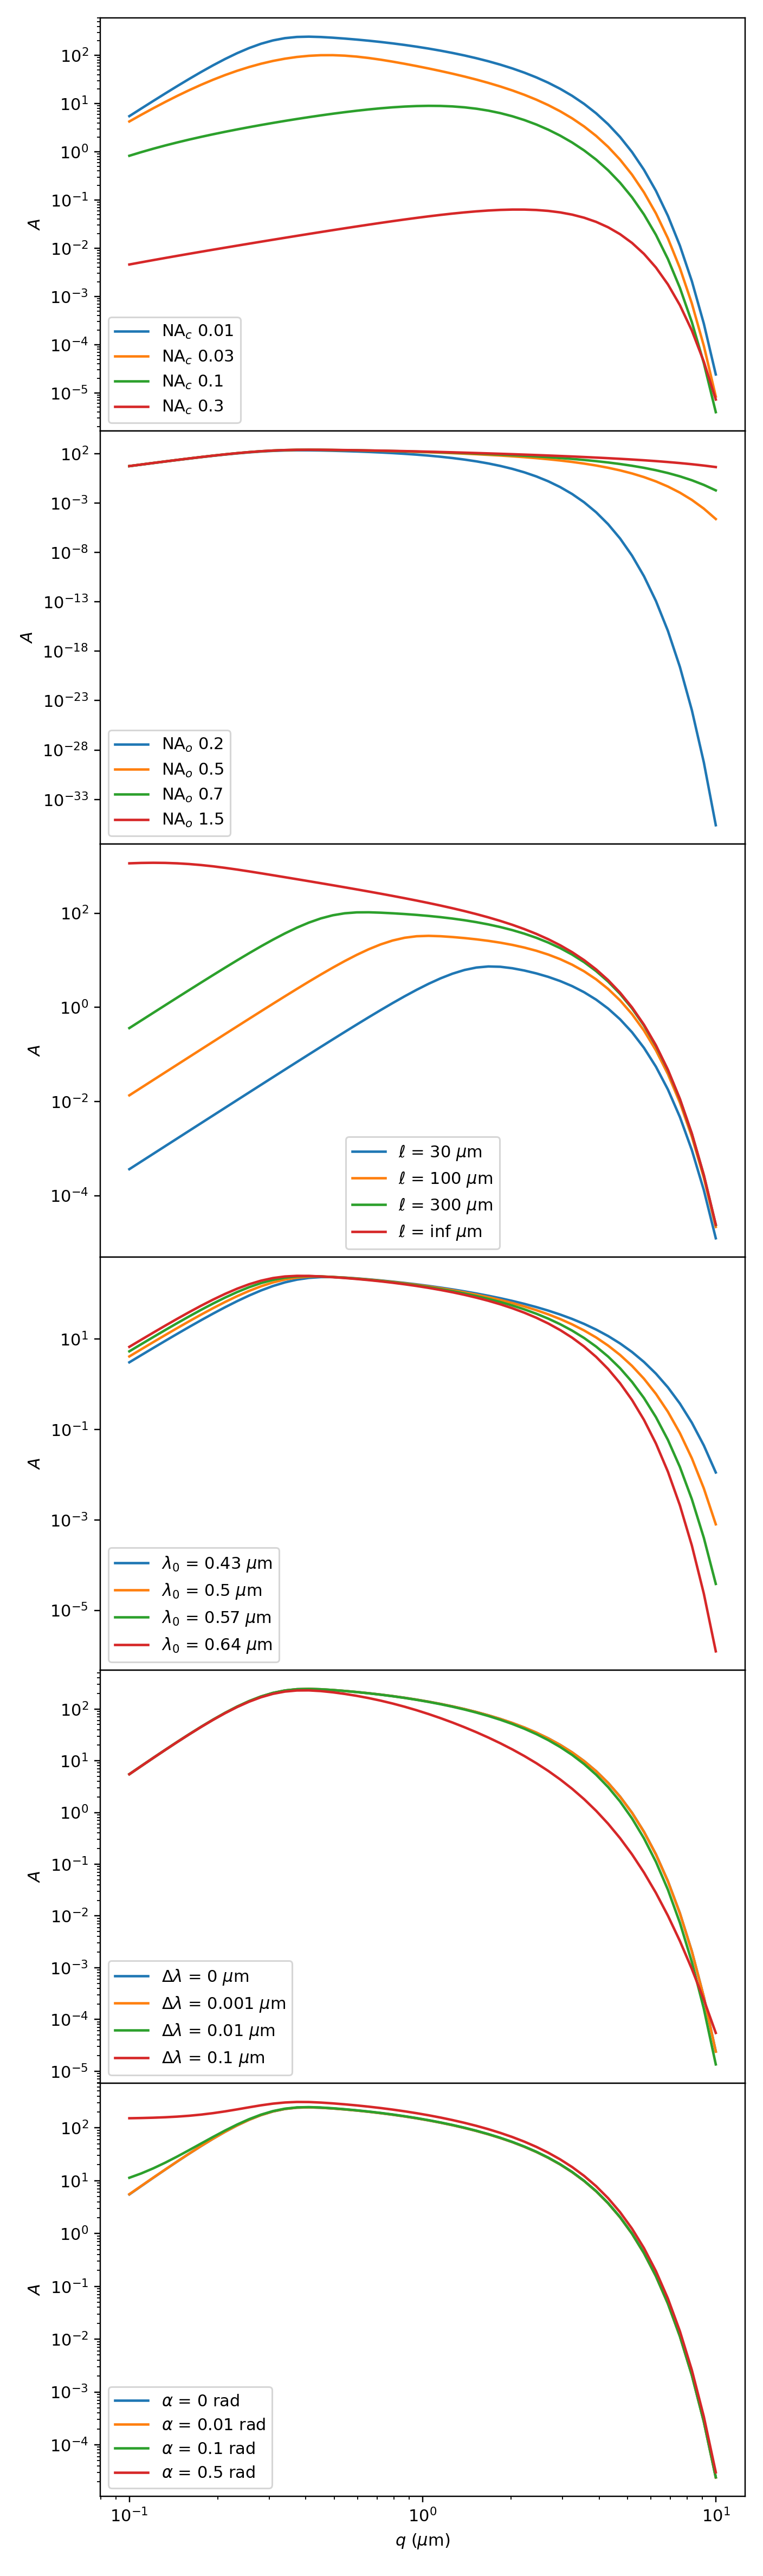

In [57]:
fig = plt.figure()
fig.set_figheight(4.5 * fig.get_figheight())
gs = fig.add_gridspec(6, hspace=0)
axs = gs.subplots(sharex=True)

# define parameters
q = np.logspace(-1, 1, num=50)
NA_c_ref = 0.01
NA_o_ref = 0.5
ell_ref = 300
lambda_0_ref = 0.580
delta_lambda_ref = 0
alpha_ref = 0

# --- vary NAc ---
for nac in [0.01, 0.03, 0.1, 0.3]:
    axs[0].plot(q, A_model(q, 1, nac, NA_o_ref, ell_ref, lambda_0_ref, delta_lambda_ref, alpha_ref), '-', label=f'NA$_c$ {nac}')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$A$')
axs[0].legend()

# --- vary NAo ---
for nao in [0.2, 0.5, 0.7, 1.5]:
    axs[1].plot(q, A_model(q, 1, NA_c_ref, nao, ell_ref, lambda_0_ref, delta_lambda_ref, alpha_ref), '-', label=f'NA$_o$ {nao}')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$')
axs[1].legend()

# --- vary ell ---
for ell in [30, 100, 300, np.inf]:
    axs[2].plot(q, A_model(q, 1, NA_c_ref, NA_o_ref, ell / np.sqrt(2 * np.pi), lambda_0_ref, delta_lambda_ref, alpha_ref), '-', label=f'$\ell$ = {ell} $\mu$m')
axs[2].set_yscale('log')
axs[2].set_ylabel(r'$A$')
axs[2].legend()

# --- vary lambda_0 ---
for l0 in [0.43, 0.50, 0.57, 0.64]:
    axs[3].plot(q, A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref, l0, delta_lambda_ref, alpha_ref), '-', label=f'$\lambda_0$ = {l0} $\mu$m')
axs[3].set_yscale('log')
axs[3].set_ylabel(r'$A$')
axs[3].legend()

# --- vary delta_lambda ---
for dl in [0, 0.001, 0.01, 0.1]:
    axs[4].plot(q, A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref, lambda_0_ref, dl, alpha_ref), '-', label=f'$\Delta \lambda$ = {dl} $\mu$m')
axs[4].set_yscale('log')
axs[4].set_ylabel(r'$A$')
axs[4].legend()

# --- vary alpha ---
for a in [0, 0.01, 0.1, 0.5]:
    axs[5].plot(q, A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref, lambda_0_ref, delta_lambda_ref, a), '-', label=r'$\alpha$ = ' + f'{a} rad')
axs[5].set_yscale('log')
axs[5].set_ylabel(r'$A$')
axs[5].legend()
    
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$q$ ($\mu$m)')

fig.tight_layout();

[[Variables]]
    a_0:           59309.4546 +/- 804.047152 (1.36%) (init = 60000)
    NA_c_0:        0.03499815 +/- 4.4920e-04 (1.28%) (init = 0.0372)
    a_1:           60700.2795 +/- 1379.37797 (2.27%) (init = 60000)
    NA_c_1:        0.10019632 +/- 0.00119538 (1.19%) (init = 0.0993)
    a_2:           48644.2667 +/- 1748.61959 (3.59%) (init = 60000)
    NA_c_2:        0.15128986 +/- 0.00308753 (2.04%) (init = 0.179)
    a_3:           50530.0971 +/- 2674.65145 (5.29%) (init = 60000)
    NA_c_3:        0.26520272 +/- 0.01101869 (4.15%) (init = 0.3)
    NA_o:          0.7 (fixed)
    l:             133.869381 +/- 1.27098570 (0.95%) (init = 119.6827)
    lambda_0:      0.4359765 (fixed)
    delta_lambda:  0.008582654 (fixed)
    alpha:         0.26256716 +/- 0.00298706 (1.14%) (init = 0.2416351)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_0, NA_c_0)    = 0.986
    C(a_1, NA_c_1)    = 0.921
    C(a_2, NA_c_2)    = 0.863
    C(l, alpha)       = -0.852
    C(a_3, NA_c_

<IPython.core.display.Javascript object>


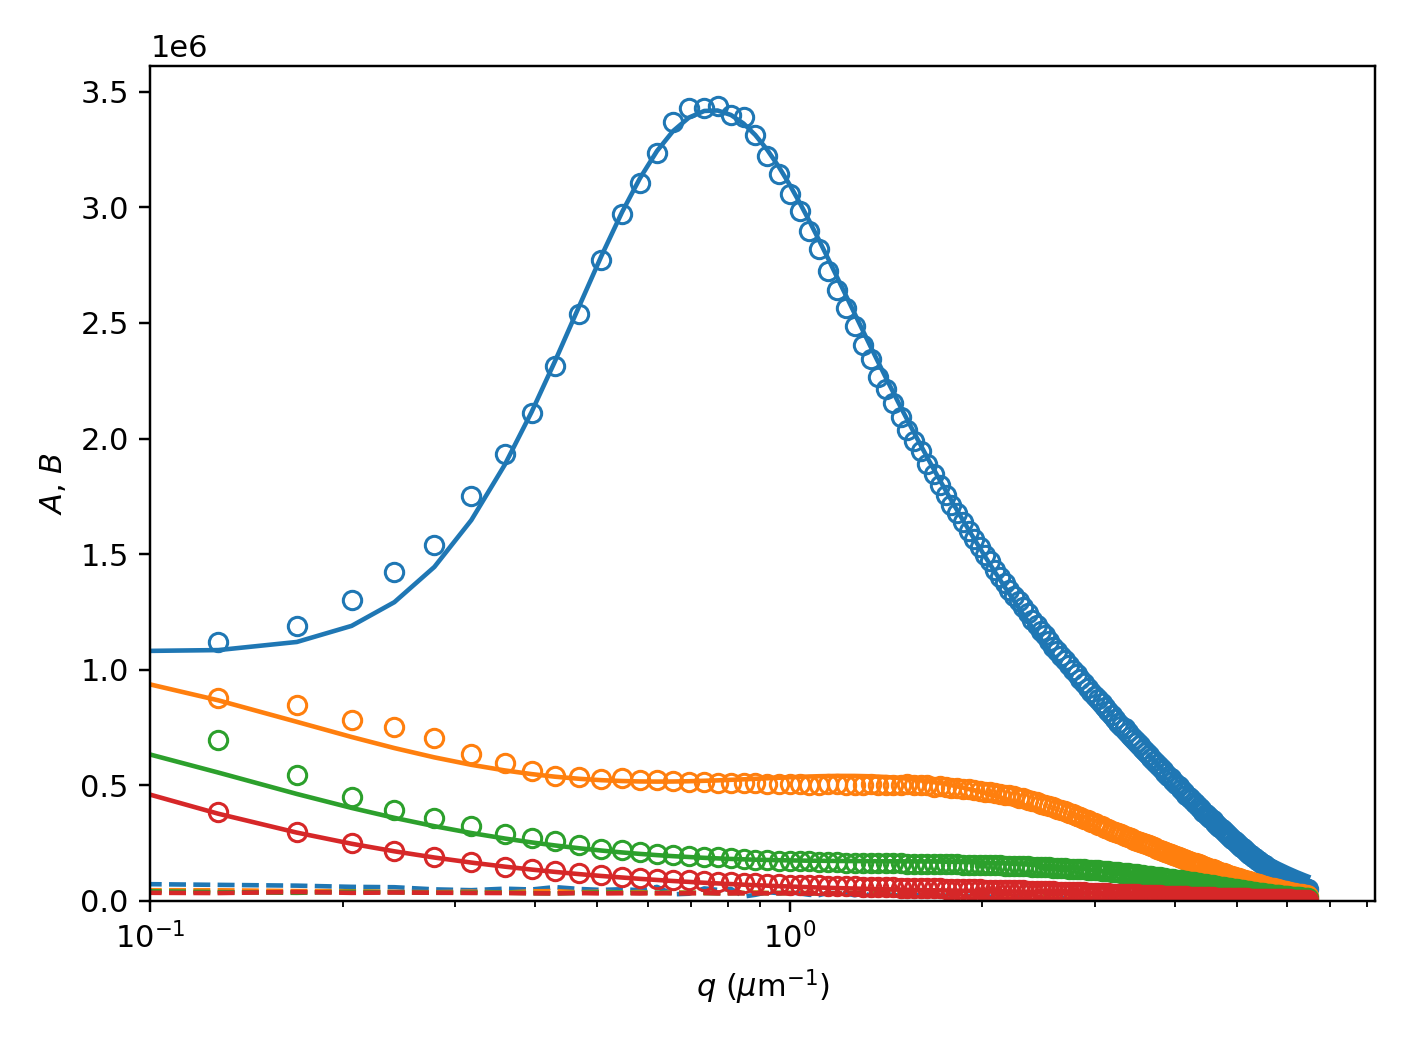

In [36]:
# fit at fixed calculated phase and varying NAc
params = Parameters()

# the amplitude and the numerical aperture of the condenser are specific for each measurement
for n, NA in enumerate(NA_c):
    params.add(f'a_{n}', min=0.0, value=6e4)
    params.add(f'NA_c_{n}', min=0.0, max=0.5, value=NA, vary=True)

# add other parameters
params.add('NA_o', value=0.7, vary=False)
params.add('l', min=300/np.sqrt(2*np.pi)*0.2, max=300/np.sqrt(2*np.pi)*5, value=300/np.sqrt(2*np.pi), vary=True)
params.add('lambda_0', value=spectrum_fit_res.params["mu"].value / 1e3, vary=False)
params.add('delta_lambda', value=spectrum_fit_res.params["sigma"].value / 1e3, vary=False)
params.add('alpha', value=phase, vary=True)

x = np.empty(0)
data = np.empty(0)
start_idx = [0]
for fr in fit_res_filtered:
    x = np.concatenate((x, fr.k))
    data = np.concatenate((data, fr.A))
    start_idx.append(len(fr))

# do cumulative sum
start_idx = np.cumsum(start_idx)

# do global fit
out = minimize(objective, params, args=(x, data, start_idx))
report_fit(out.params)

# plot fit results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, fr in enumerate(fit_res_filtered):
    # plot A
    ax.plot(fr.k, fr.A, f'C{n}o', markerfacecolor='none', label=labels[n])
    
    # plot A fit
    y_fit = A_dataset(out.params, n, fr.k)
    ax.plot(fr.k, y_fit, f'C{n}-')
    
    # plot B
    ax.plot(fr.k, fr.B, f'C{n}--')
    
ax.set_xscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$, $B$')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0.1)

fig.tight_layout()

<IPython.core.display.Javascript object>


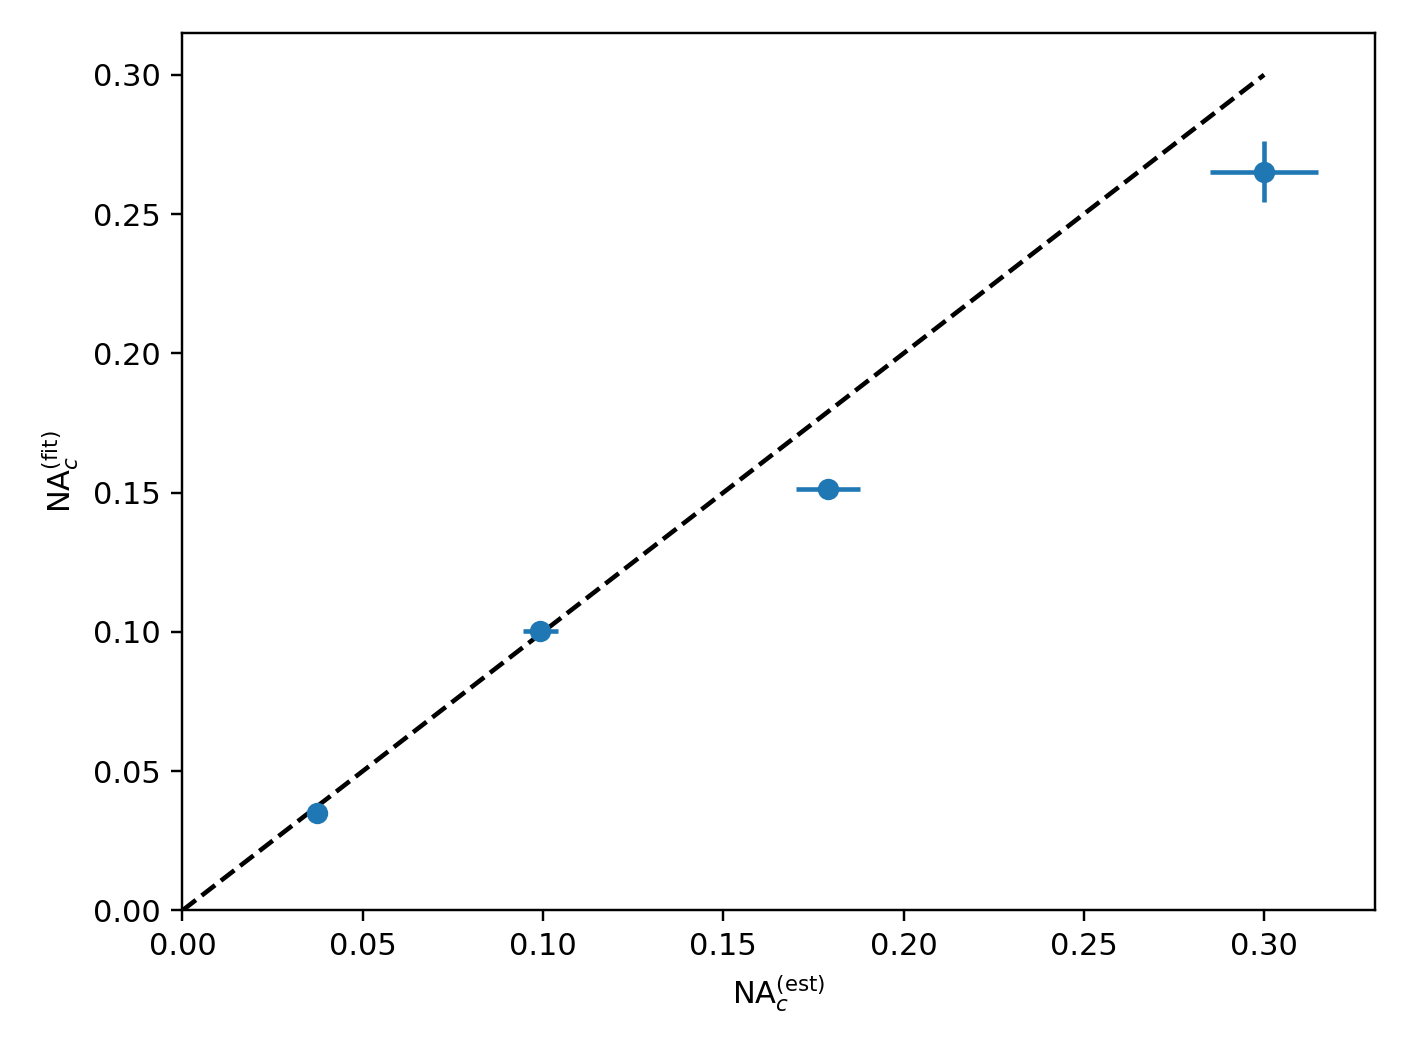

In [60]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

NA_c_fit = [out.params[f'NA_c_{n}'].value for n in range(4)]
NA_c_fit_err = [out.params[f'NA_c_{n}'].stderr for n in range(4)]

ax.errorbar(NA_c, NA_c_fit, yerr=NA_c_fit_err, xerr=0.05*np.array(NA_c), fmt='o', markersize=6)
ax.plot([0]+NA_c, [0]+NA_c, 'k--')

ax.set_xlabel(r'$\mathrm{NA}_c^{(\mathrm{est})}$')
ax.set_ylabel(r'$\mathrm{NA}_c^{(\mathrm{fit})}$')

ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)

fig.tight_layout();